In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install keras-tqdm

In [4]:
%tensorflow_version 1.x

import cv2
import json
import os

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.applications.densenet import DenseNet121
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau

from keras_tqdm import TQDMNotebookCallback

import keras.backend as K

import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [0]:
# Utility functions

# Plot loss and accuracy curve for 'age'
def plot_loss_acc_age(history):

  acc = history.history['age_output_acc']
  val_acc = history.history['val_age_output_acc']
  loss = history.history['age_output_loss']
  val_loss = history.history['val_age_output_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc(age)')
  plt.plot(epochs, val_acc, 'r', label='Validation acc(age)')
  plt.grid(True)
  plt.title('Training and validation accuracy(age)')
  plt.legend()
  
  plt.figure()
  
  plt.plot(epochs, loss, 'b', label='Training loss(age)')
  plt.plot(epochs, val_loss, 'r', label='Validation loss(age)')
  plt.grid(True)
  plt.title('Training and validation loss (age)')
  plt.legend()
  
  plt.show()

# Plot loss and accuracy curve for 'gender'
def plot_loss_acc_gender(history):

  acc = history.history['gender_output_acc']
  val_acc = history.history['val_gender_output_acc']
  loss = history.history['gender_output_loss']
  val_loss = history.history['val_gender_output_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc(gender)')
  plt.plot(epochs, val_acc, 'r', label='Validation acc(gender)')
  plt.grid(True)
  plt.title('Training and validation accuracy(gender)')
  plt.legend()
  
  plt.figure()
  
  plt.plot(epochs, loss, 'b', label='Training loss(gender)')
  plt.plot(epochs, val_loss, 'r', label='Validation loss(gender)')
  plt.grid(True)
  plt.title('Training and validation loss (gender)')
  plt.legend()
  
  plt.show()

In [0]:
# Plot the model accuracy for each epoch.
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 9, figsize=(20, 5))

    # loss
    axes[0].plot(history.history['loss'], label='Training loss')
    axes[0].plot(history.history['val_loss'], label='Validation loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    # Age
    axes[1].plot(history.history['age_output_acc'], label='Age Train accuracy')
    axes[1].plot(history.history['val_age_output_acc'], label='Age Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()  
    
    # Gender
    axes[2].plot(history.history['gender_output_acc'], label='Gender Train accuracy')
    axes[2].plot(history.history['val_gender_output_acc'], label='Gener Val accuracy')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    # Emotion
    axes[3].plot(history.history['emotion_output_acc'], label='Emotion Train accuracy')
    axes[3].plot(history.history['val_emotion_output_acc'], label='Emotion Val accuracy')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

    # weight
    axes[4].plot(history.history['weight_output_acc'], label='weight Train accuracy')
    axes[4].plot(history.history['val_weight_output_acc'], label='weight Val accuracy')
    axes[4].set_xlabel('Epochs')
    axes[4].legend()

    # bag
    axes[5].plot(history.history['bag_output_acc'], label='bag Train accuracy')
    axes[5].plot(history.history['val_bag_output_acc'], label='bag Val accuracy')
    axes[5].set_xlabel('Epochs')
    axes[5].legend()

    # footwear
    axes[6].plot(history.history['footwear_output_acc'], label='footwear Train accuracy')
    axes[6].plot(history.history['val_footwear_output_acc'], label='footwear Val accuracy')
    axes[6].set_xlabel('Epochs')
    axes[6].legend()

    # pose
    axes[7].plot(history.history['pose_output_acc'], label='pose Train accuracy')
    axes[7].plot(history.history['val_pose_output_acc'], label='pose Val accuracy')
    axes[7].set_xlabel('Epochs')
    axes[7].legend()

    # image_quality
    axes[8].plot(history.history['image_quality_output_acc'], label='image_quality Train accuracy')
    axes[8].plot(history.history['val_image_quality_output_acc'], label='image_quality Val accuracy')
    axes[8].set_xlabel('Epochs')
    axes[8].legend()

In [7]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

gender imagequality    age  ...        emotion        bodypose     image_path
0    male      Average  35-45  ...        Neutral  Front-Frontish  resized/1.jpg
1  female      Average  35-45  ...  Angry/Serious  Front-Frontish  resized/2.jpg
2    male         Good  45-55  ...        Neutral  Front-Frontish  resized/3.jpg
3    male         Good  45-55  ...        Neutral  Front-Frontish  resized/4.jpg
4  female         Good  35-45  ...        Neutral  Front-Frontish  resized/5.jpg

[5 rows x 9 columns]

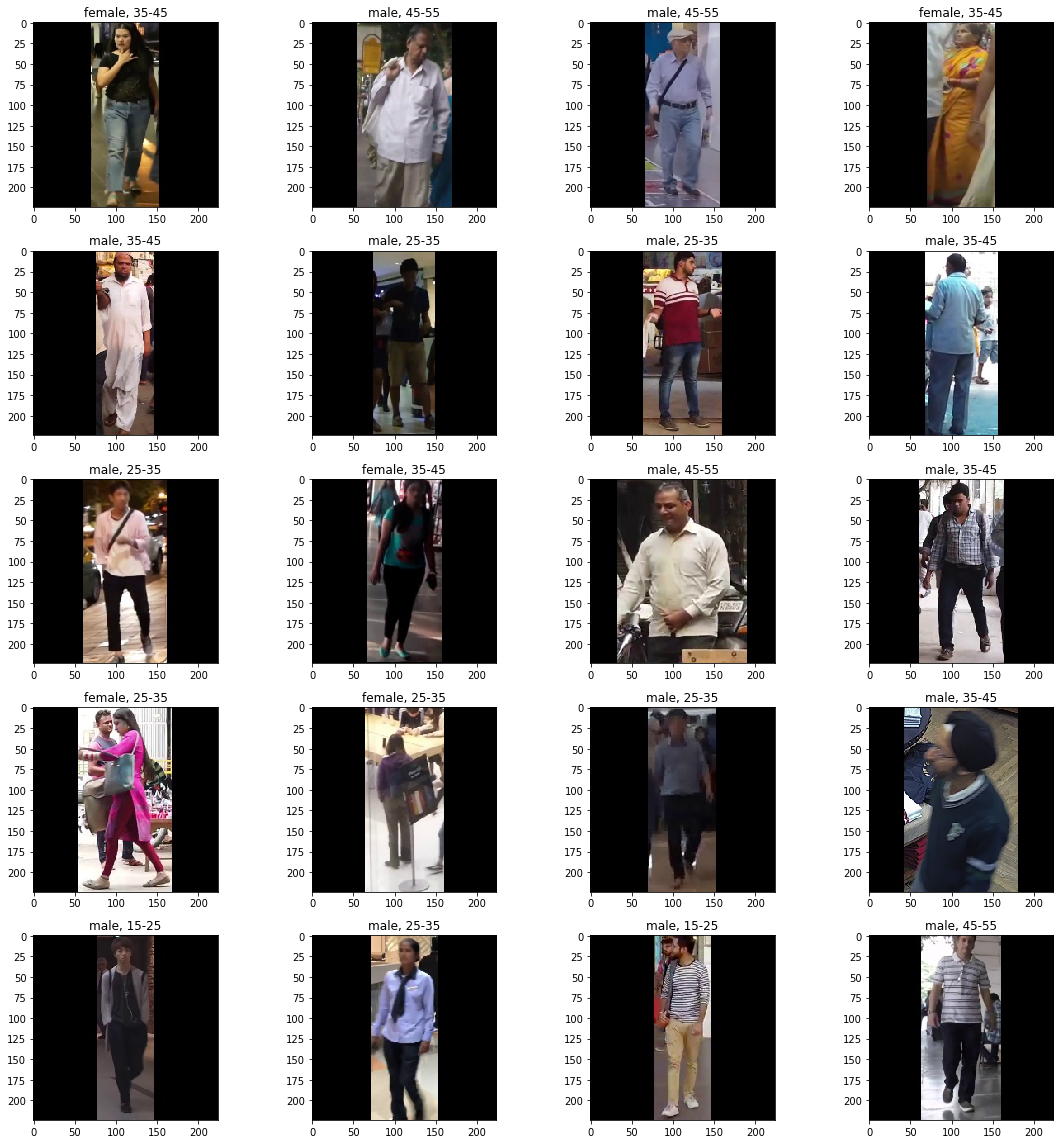

Attributes of image at index: 1
gender                  female
imagequality           Average
age                      35-45
weight             over-weight
carryingbag               None
footwear                Normal
emotion          Angry/Serious
bodypose        Front-Frontish
image_path       resized/2.jpg
Name: 1, dtype: object


In [8]:
# Print random image
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 5
ax = []

for i in range(1, columns * rows + 1):
    
    x = mpimg.imread(df.image_path[i])
    ax.append(fig.add_subplot(rows, columns, i))
    fig.tight_layout()
    ax[-1].set_title(str(df.gender[i])+", "+str(df.age[i]))
    plt.imshow(x)

plt.show()

imageIndex = 1
print("Attributes of image at index: " + str(imageIndex))
print(df.iloc[imageIndex])

In [9]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

0  ...              4
image_path                            resized/1.jpg  ...  resized/5.jpg
gender_female                                     0  ...              1
gender_male                                       1  ...              0
imagequality_Average                              1  ...              0
imagequality_Bad                                  0  ...              0
imagequality_Good                                 0  ...              1
age_15-25                                         0  ...              0
age_25-35                                         0  ...              0
age_35-45                                         1  ...              1
age_45-55                                         0  ...              0
age_55+                                           0  ...              0
weight_normal-healthy                             1  ...              0
weight_over-weight                                0  ...              0
weight_slightly-overweight                        0  ...              1
weight_underweight                                0  ...              0
carryingbag_Daily/Office/Work Bag                 0  ...              0
carryingbag_Grocery/Home/Plastic Bag              1  ...              0
carryingbag_None                                  0  ...              1
footwear_CantSee                                  0  ...              1
footwear_Fancy                                    0  ...              0
footwear_Normal                                   1  ...              0
emotion_Angry/Serious                             0  ...              0
emotion_Happy                                     0  ...              0
emotion_Neutral                                   1  ...              1
emotion_Sad                                       0  ...              0
bodypose_Back                                     0  ...              0
bodypose_Front-Frontish                           1  ...              1
bodypose_Side                                     0  ...              0

[28 rows x 5 columns]

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation=augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image/255.0, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2, random_state=42, shuffle=False)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [12]:
train_df.head()

image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
0  resized/1.jpg              0  ...                        1              0
1  resized/2.jpg              1  ...                        1              0
2  resized/3.jpg              0  ...                        1              0
3  resized/4.jpg              0  ...                        1              0
4  resized/5.jpg              1  ...                        1              0

[5 rows x 28 columns]

In [0]:
# create train and validation data generators
# train_gen = PersonDataGenerator(train_df, batch_size=32)
train_gen = PersonDataGenerator(train_df, 
                                batch_size=32, 
                                augmentation=ImageDataGenerator( 
                                    # set input mean to 0 over the dataset 
                                    featurewise_center=False, 
                                    # set each sample mean to 0 
                                    samplewise_center=False, 
                                    # divide inputs by std of dataset 
                                    featurewise_std_normalization=False, 
                                    # divide each input by its std 
                                    samplewise_std_normalization=False, 
                                    # apply ZCA whitening 
                                    zca_whitening=False, 
                                    # epsilon for ZCA whitening 
                                    zca_epsilon=1e-06, 
                                    # randomly rotate images in the range (deg 0 to 180) 
                                    rotation_range=0, 
                                    # randomly shift images horizontally 
                                    width_shift_range=0.1, 
                                    # randomly shift images vertically 
                                    height_shift_range=0.1, 
                                    # set range for random shear 
                                    shear_range=0.15, 
                                    # set range for random zoom 
                                    zoom_range=0., 
                                    # set range for random channel shifts 
                                    channel_shift_range=0., 
                                    # set mode for filling points outside the input boundaries 
                                    fill_mode='nearest', 
                                    # value used for fill_mode = "constant" 
                                    cval=0., 
                                    # randomly flip images 
                                    horizontal_flip=True, 
                                    # randomly flip images 
                                    vertical_flip=False, 
                                    # set rescaling factor (applied before any other transformation) 
                                    rescale=None, 
                                    # set function that will be applied on each input 
                                    preprocessing_function=None, 
                                    # image data format, either "channels_first" or "channels_last" 
                                    data_format=None, 
                                    # fraction of images reserved for validation (strictly between 0 and 1) 
                                    validation_split=0.0))


valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [14]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

# **Pre-trained Model : DenseNet121**


In [0]:
# Denset function
# Note: Start with 64 filters 
# In dense block the 1 x 1 has 4 * filters and we concatenate input with output tensor
# In transition reduce channels to half of the existing


from keras.models import Model
from keras.layers import Input, BatchNormalization, ReLU
from keras.layers import Conv2D, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Dense, concatenate

def densenet(input_shape, n_classes, f = 32):

    def bn_relu_conv(x, f, k=1, s=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(f, k, strides = s, padding = 'same')(x)
        return x
    
    def dense_block(x, r):
        for _ in range(r):
            y = bn_relu_conv(x, 4 * f)
            y = bn_relu_conv(y, f, 3)
            x = concatenate([y, x])
        return x
            
            
    def transition_layer(x):
        x = bn_relu_conv(x, keras.backend.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x
    
    input = Input(input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)

    for r in [6, 12, 24, 16]:
        d = dense_block(x, r)
        x = transition_layer(d)
    
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

In [16]:
# Create Model - Densenet 121
input_shape = (224, 224, 3)

# backbone = DenseNet121(weights=None, include_top=False, input_shape=input_shape)
base_model = densenet(input_shape, 27)
backbone = base_model.output


'''neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)'''


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    '''neck = Dropout(0.3)(neck)
    neck = Dense(128, activation="relu")(neck)'''
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(backbone))
image_quality = build_head("image_quality", build_tower(backbone))
age = build_head("age", build_tower(backbone))
weight = build_head("weight", build_tower(backbone))
bag = build_head("bag", build_tower(backbone))
footwear = build_head("footwear", build_tower(backbone))
emotion = build_head("emotion", build_tower(backbone))
pose = build_head("pose", build_tower(backbone))

model = Model(
    inputs=base_model.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# Review model
from keras.utils import plot_model

model.summary()
plot_model(model, to_file='model.png')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [22]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), '/content/drive/My Drive/Colab Notebooks/models')
model_name = 'model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print(filepath)

/content/drive/My Drive/Colab Notebooks/models/model.{epoch:03d}.h5


#### Callbacks
- Checkpoint: val_loss, save_best_only
- Early Stopping: val_loss, mode-min, Patience-10
- LossHistory



In [0]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

In [0]:
## Callback for loss logging per epoch
class LRPrint(Callback):
  def on_epoch_end(self, epoch, logs=None):
    print("Learning rate at the end of epoch: " + str(epoch) + " is " + str(K.eval(self.model.optimizer.lr)))
        
lr_print = LRPrint()

In [0]:
# LR Finder
!git clone https://github.com/WittmannF/LRFinder.git
from LRFinder.keras_callback import LRFinder

lr_finder = LRFinder(min_lr=1e-10, max_lr=10.0)

Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 71 (delta 24), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [0]:
def lr_schedule(epoch):

    lr = 0.1
    if epoch > 90:
        lr *= 0.5e-3
    elif epoch > 60:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1

    print('Learning Rate: ', lr)
    return lr

In [19]:
# Cyclic LR
!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

batch_size = 64
epochs = 200
cycles = 8

iterations = round(len(train_df)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

clr = CyclicLR(
	base_lr=0.0001,
  max_lr=0.1,  
  step_size=step_size,
  mode='triangular'	
	)

Cloning into 'CLR'...
remote: Enumerating objects: 244, done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (244/244), 1.37 MiB | 4.22 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [25]:
# Prepare callbacks for model saving and for learning rate adjustment.
# filePath = 'weights.best.hdf5'
print(filepath)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0,
                              patience=5, min_lr=1e-10)

# lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# callbacks = [checkpoint, lr_scheduler]
# callbacks = [checkpoint, es, reduce_lr, lr_print, clr] # , lr_scheduler]
callbacks = [checkpoint, clr, lr_print]

/content/drive/My Drive/Colab Notebooks/models/model.{epoch:03d}.h5


In [26]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"
}

loss_weights = {
    "gender_output": 1.5,
    "image_quality_output": 1.5, 
    "age_output": 2, 
    "weight_output": 1.2, 
    "bag_output": 1.2, 
    "footwear_output": 1.5, 
    "pose_output": 1.0, 
    "emotion_output": 1.0
}

# opt = SGD(lr=0.01, momentum=0.9)
# opt = SGD(lr=lr_schedule(0), momentum=0.9)
model.compile(
    optimizer='sgd',
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

lr = K.get_value(model.optimizer.lr)
print(lr)



0.01


In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [27]:
H = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=1, 
    epochs=200,
    verbose=1,
    callbacks=callbacks
)

# First Pass loss and accuracy
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
339/339 [==============================] - 141s 416ms/step - loss: 8.8127 - gender_output_loss: 0.6899 - image_quality_output_loss: 1.0398 - age_output_loss: 1.5527 - weight_output_loss: 1.1991 - bag_output_loss: 1.0594 - footwear_output_loss: 1.0730 - pose_output_loss: 1.0142 - emotion_output_loss: 1.1847 - gender_output_acc: 0.5336 - image_quality_output_acc: 0.5415 - age_output_acc: 0.3439 - weight_output_acc: 0.5914 - bag_output_acc: 0.4478 - footwear_output_acc: 0.4450 - pose_output_acc: 0.6127 - emotion_output_acc: 0.6872 - val_loss: 7.9524 - val_gender_output_loss: 0.6861 - val_image_quality_output_loss: 0.9770 - val_age_output_loss: 1.4551 - val_weight_output_loss: 1.0058 - val_bag_output_loss: 0.9621 - val_footwear_output_loss: 1.0411 - val_pose_output_loss: 0.9271 - val_emotion_output_loss: 0.8981 - val_gender_output_acc: 0.5592 - val_image_quality_output_acc: 0.5815 - 

{'age_output_acc': 0.42224702380952384,
 'age_output_loss': 3.240972944668361,
 'bag_output_acc': 0.5569196428571429,
 'bag_output_loss': 2.3991143192563738,
 'emotion_output_acc': 0.6934523809523809,
 'emotion_output_loss': 2.0278023225920543,
 'footwear_output_acc': 0.6290922619047619,
 'footwear_output_loss': 1.6991851528485615,
 'gender_output_acc': 0.8497023809523809,
 'gender_output_loss': 0.8426134380556288,
 'image_quality_output_acc': 0.5654761904761905,
 'image_quality_output_loss': 1.50063210158121,
 'loss': 14.37654549734933,
 'pose_output_acc': 0.8098958333333334,
 'pose_output_loss': 1.0435083082744054,
 'weight_output_acc': 0.6369047619047619,
 'weight_output_loss': 1.6227167298396428}

##### Results


In [28]:
# First Pass loss and accuracy
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

42/42 [==============================] - 7s 168ms/step


{'age_output_acc': 0.42224702380952384,
 'age_output_loss': 3.240972944668361,
 'bag_output_acc': 0.5569196428571429,
 'bag_output_loss': 2.3991143192563738,
 'emotion_output_acc': 0.6934523809523809,
 'emotion_output_loss': 2.0278023225920543,
 'footwear_output_acc': 0.6290922619047619,
 'footwear_output_loss': 1.6991851528485615,
 'gender_output_acc': 0.8497023809523809,
 'gender_output_loss': 0.8426134380556288,
 'image_quality_output_acc': 0.5654761904761905,
 'image_quality_output_loss': 1.50063210158121,
 'loss': 14.37654549734933,
 'pose_output_acc': 0.8098958333333334,
 'pose_output_loss': 1.0435083082744054,
 'weight_output_acc': 0.6369047619047619,
 'weight_output_loss': 1.6227167298396428}

##### Plots
Train and Validation loss

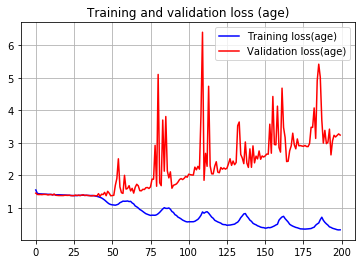

In [29]:
plot_loss_acc_age(H)

In [30]:
plot_loss_acc_gender(H)

In [31]:
plot_train_history(H)

#### Test Prediction

In [32]:
predictions= model.predict_generator(valid_gen)
len(predictions[0])

2688

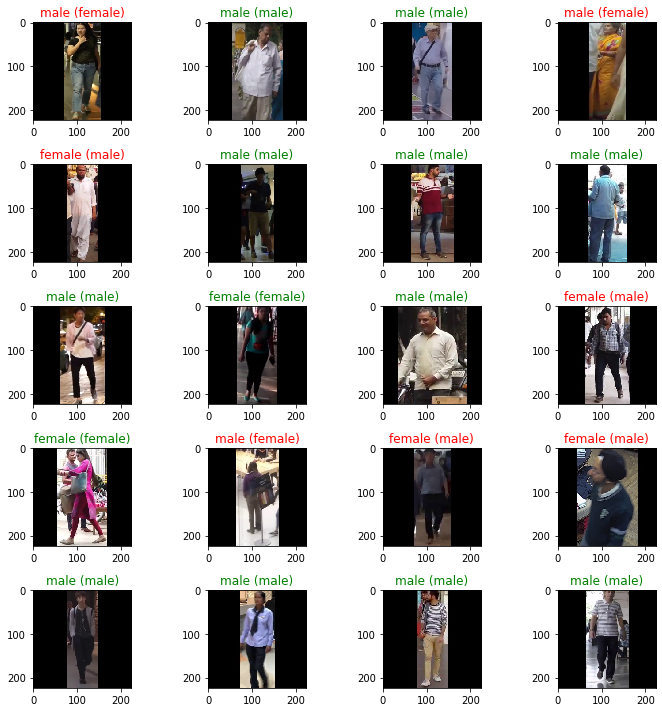

In [33]:
# Print predictions - gender
fig = plt.figure(figsize=(10, 10))

columns = 4
rows = 5
ax = []
gender = ['female', 'male']

for i in range(1, columns * rows + 1):
    
    gender_pred_index = np.argmax(predictions[0][i], axis=-1)
    gender_true_index = gender.index(df.gender[i])
    
    x = mpimg.imread(df.image_path[i])
    ax.append(fig.add_subplot(rows, columns, i))
    fig.tight_layout() 
    ax[-1].set_title("{} ({})".format(gender[gender_pred_index], 
                                  gender[gender_true_index]),
                                  color=("green" if gender_pred_index == gender_true_index else "red"))
    plt.imshow(x)

plt.show()

In [34]:
def get_misclassified_gender(predictions):
  
  misclassifieds = []
  for i in range(len(predictions[0])):
    
    # Index 0 corresponds to gender
    gender_pred_index = np.argmax(predictions[0][i], axis=-1)
    gender_true_index = gender.index(df.gender[i])
    if gender_pred_index == gender_true_index:
      misclassifieds.append(i)

  return len(misclassifieds)


misclassfied_gender_count = get_misclassified_gender(predictions)

print("Total predictions: "+str(len(predictions[0])))
print("Total Misclassifieds: "+str(misclassfied_gender_count))

Total predictions: 2688
Total Misclassifieds: 1332
